# Random Forest Example: Cloud-resolving model sensitivity

In this example, we will use an ensemble of large-domain simulations of realistic shallow cloud fields to explore the sensitivity of shallow precipitation to local changes in the environment. 

The simulation data we use for training the emulator is taken from a recent study Dagan and Stier (2020), where they performed ensemble daily simulations for one month-long period during December 2013 over the ocean to the East of Barbados, such that they samepled variability associated with shallow convection. Each day of the month consisted of two runs, both forced by realistic boundary conditions taken from reanalysis, but with different cloud droplet number concentrations (CDNC) to represent clean and polluted conditions. The altered CDNC was found to have little impact on the precipitation rate in the simulations, and so we simply treat the CDNC change as a perturbation to the initial conditions, and combine the two CDNC runs from each day together to increase the amount of data available for training the emulator. At hourly resolution, this provides us with 1488 data points.

However, given that the amount of precipitation is strongly tied to the local cloud regime, not fully controlling for cloud regime can introduce spurious correlations when training the emulator. As such we also filter out all hours which are not associated with shallow convective clouds. To do this, we consider domain-mean vertical profiles of total cloud water content (liquid + ice), q$_{t}$, and filter out all hours where the vertical sum of q$_{t}$ below 600hPa exceeds 10$^{-6}$ kg/kg. This condition allows us to filter out hours associated with the onset and development of deep convection in the domain, as well as masking out hours with high cirrus layers or hours dominated by transient mesoscale convective activity which is advected in by the boundary conditions. After this, we are left with 850 hourly data point which meet our criteria and can be used to train the emulator.

In this example we emulate hourly `precip` using domain-mean features: `liquid water path` (LWP), `geopotential height at 700hPa` (z$_{700}$), `Estimated Inversion Strength` (EIS), `sea-surface temperature` (SST) and the `vertical pressure velocity at 700hPa` (w700). 

<img src="barbados.png" style="width:500px">

**References:**

Dagan, G. and Stier, P.: Ensemble daily simulations for elucidating cloud–aerosol interactions under a large spread of realistic environmental conditions, Atmos. Chem. Phys., 20, 6291–6303, https://doi.org/10.5194/acp-20-6291-2020, 2020.

In [1]:
import numpy as np
import pandas as pd
import iris

from utils import get_crm_data
from esem.utils import plot_results, prettify_plot, add_121_line, leave_one_out

from esem import rf_model

from matplotlib import pyplot as plt
plt.style.use('default')
%matplotlib inline

Concatenate 20cdnc and 200cdnc runs into one dataframe

In [2]:
df_crm = get_crm_data()
df_crm

,precip,pres_msl,LWP,WS10,lhfl_s,shfl_s,LTS,w500,w600,w700,wmax850,wstd850,zg500,zg600,zg700,rh850,rh700,u_shear,EIS,SST
0,0.004593,101407.410,0.035898,6.639860,-167.53857,5.745860,13.180252,-0.014463,-0.012311,-0.010275,-0.000024,0.000947,56627.516,42694.220,30541.566,67.243774,60.067740,-4.662799,0.989443,301.173248
1,0.006900,101356.266,0.044468,6.822748,-176.93939,4.438721,13.279678,-0.015064,-0.012710,-0.008676,0.000030,0.000382,56572.645,42640.473,30488.172,69.299180,58.453730,-4.322696,1.130803,301.173248
2,0.008916,101316.420,0.051559,6.798490,-182.61697,3.649221,13.333527,-0.014811,-0.012014,-0.006025,0.000642,0.000511,56525.613,42593.594,30442.703,71.522900,56.912193,-3.925541,1.242463,301.173248
3,0.008932,101270.490,0.057509,6.756970,-188.87599,3.033055,13.328018,-0.013470,-0.012141,-0.004758,0.001519,0.000476,56471.332,42539.062,30390.662,74.115690,55.652990,-3.556973,1.304206,301.173248
4,0.016204,101256.270,0.064226,6.763690,-194.85498,2.826119,13.317032,-0.010917,-0.011119,-0.003158,0.003252,0.000958,56443.758,42510.805,30364.852,77.510765,54.434470,-3.319007,1.362710,301.173248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,0.063121,101309.750,0.064794,8.253145,-191.23718,12.219704,10.142059,-0.024480,-0.006400,-0.007968,-0.000044,0.001105,56084.273,42214.140,30222.945,83.696740,77.278465,-5.993636,-2.696190,300.126465
846,0.064601,101303.110,0.063914,8.326073,-192.57118,11.947702,10.162674,-0.019426,0.000300,-0.003904,-0.000034,0.000588,56071.547,42206.734,30214.715,84.196236,77.536760,-5.848422,-2.673406,300.126465
847,0.046773,101332.234,0.059974,8.404624,-193.80084,12.372276,10.166580,-0.014384,0.004355,-0.000284,-0.000251,0.000650,56079.492,42225.984,30236.312,84.394960,77.754560,-5.663757,-2.643809,300.126465
848,0.056623,101394.280,0.062895,8.385845,-192.18195,13.336615,10.149658,-0.016936,0.002702,0.000667,0.000013,0.000509,56117.140,42272.740,30286.500,84.437530,78.009740,-5.427930,-2.635981,300.126465


Extract the precipitation timeseries as target data

In [3]:
precip = df_crm['precip'].to_numpy().reshape(-1 ,1)

## Visualize the precipitation landscape

In the ensemble, shallow precipitation is highly correlated with many different physical features. Most obviously there is a high correlation with liquid water path (`LWP`), 10-metre windspeed (`WS10`) and geopotential height at 700hPa (`z_{700}`). 

We can use these correlations to create "collapsing spaces" for investigating the relationships between shallow precipitation and the local meteorological environment.

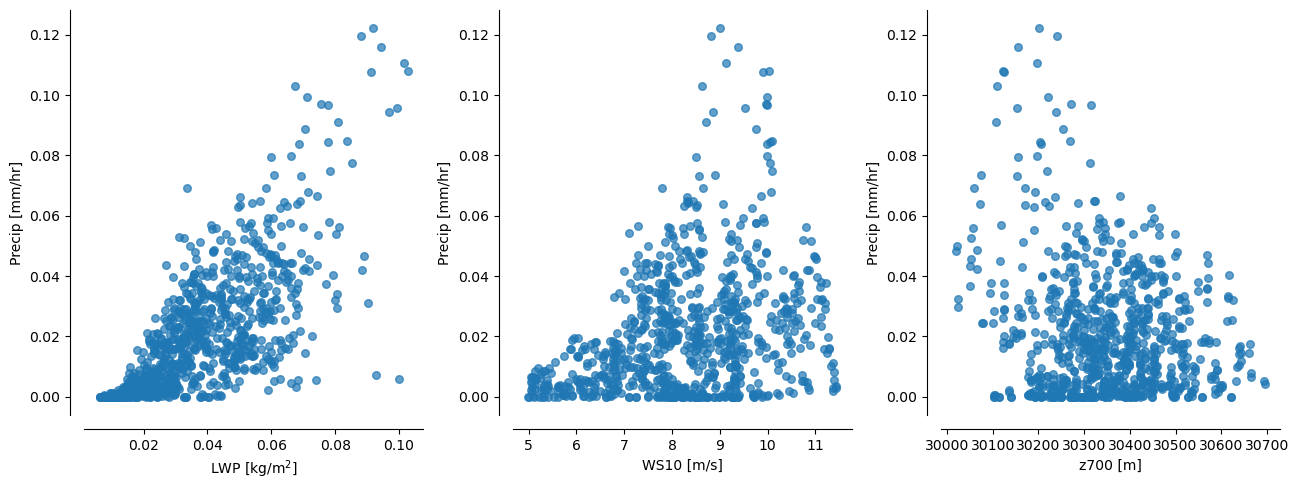

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(13,5), dpi=100, gridspec_kw={'width_ratios':[1,1,1]})

axs[0].scatter(df_crm['LWP'], df_crm['precip'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[0].set_xlabel('LWP [kg/m$^{2}$]')
axs[0].set_ylabel('Precip [mm/hr]')
prettify_plot(axs[0])

axs[1].scatter(df_crm['WS10'], df_crm['precip'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[1].set_xlabel('WS10 [m/s]')
axs[1].set_ylabel('Precip [mm/hr]')
prettify_plot(axs[1])

axs[2].scatter(df_crm['zg700'], df_crm['precip'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[2].set_xlabel('z700 [m]')
axs[2].set_ylabel('Precip [mm/hr]')
prettify_plot(axs[2])

fig.tight_layout()
#plt.savefig("Figs/1hr_D13shal_lwp-ws-pr.png", dpi=200)

**Also, good to note that each of these predictors `(LWP, WS10, z700)` are mutually uncorrelated (see plots below)**

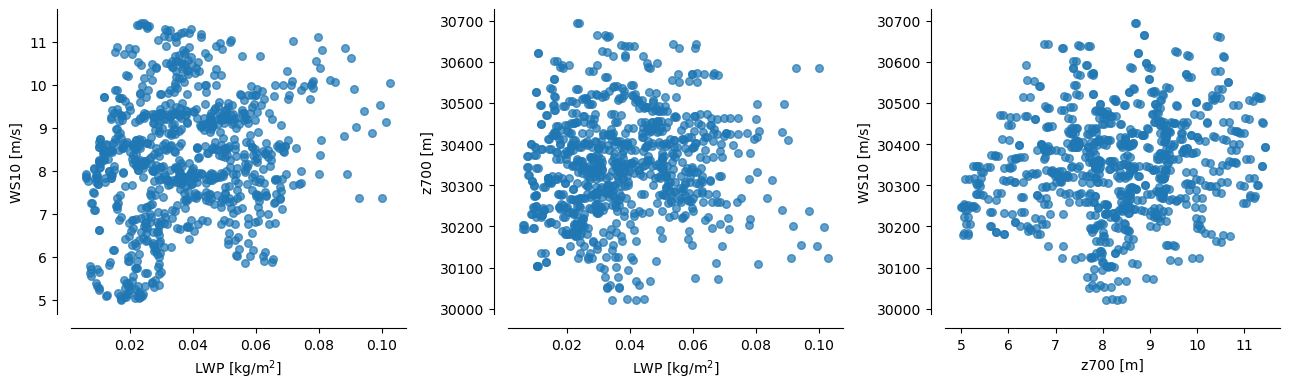

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(13,4), dpi=100, gridspec_kw={'width_ratios':[1,1,1]})

axs[0].scatter(df_crm['LWP'], df_crm['WS10'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[0].set_xlabel('LWP [kg/m$^{2}$]')
axs[0].set_ylabel('WS10 [m/s]')
prettify_plot(axs[0])

axs[1].scatter(df_crm['LWP'], df_crm['zg700'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[1].set_xlabel('LWP [kg/m$^{2}$]')
axs[1].set_ylabel('z700 [m]')
prettify_plot(axs[1])

axs[2].scatter(df_crm['WS10'], df_crm['zg700'], s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')
axs[2].set_xlabel('z700 [m]')
axs[2].set_ylabel('WS10 [m/s]')
prettify_plot(axs[2])

fig.tight_layout()
#plt.savefig("Figs/1hr_D13shal_lwp-ws-pr.png", dpi=200)

**Stratifying precip by pairs of these predictors creates nice "collapsing spaces"**

Nice for illustrating how the emulated surface compares to the raw data

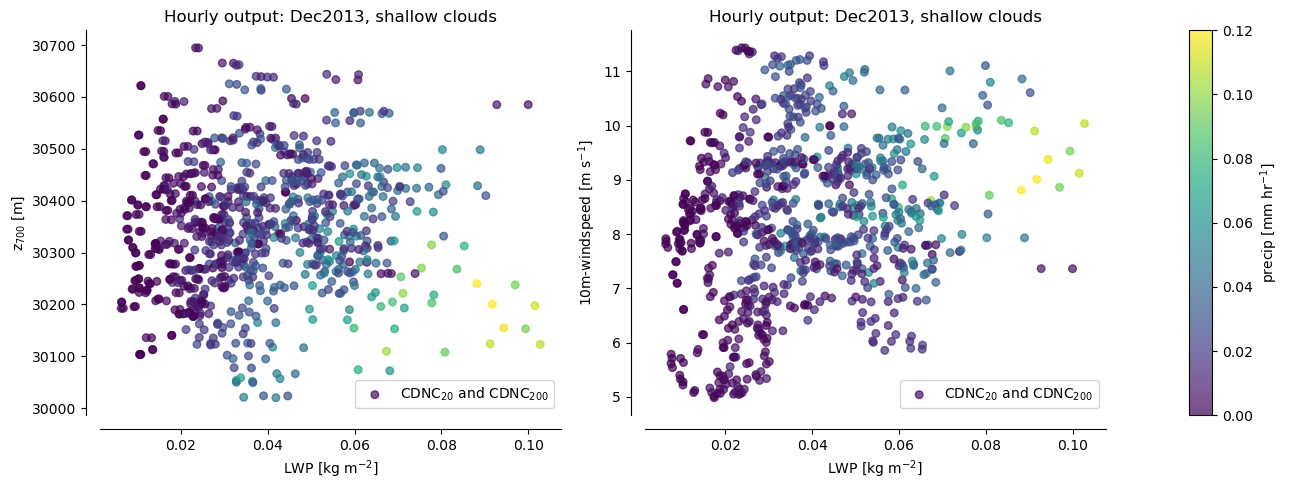

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(13,5), dpi=100, gridspec_kw={'width_ratios':[1,1,0.05]})

sc1 = axs[0].scatter(df_crm['LWP'], df_crm['zg700'], c=df_crm['precip'], 
                vmin=0, vmax=0.12, s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')

axs[0].set_xlabel(r'LWP [kg m$^{-2}$]')
axs[0].set_ylabel(r'z$_{700}$ [m]')

axs[0].set_title("Hourly output: Dec2013, shallow clouds")
axs[0].legend(loc='lower right')

prettify_plot(axs[0])


sc2 = axs[1].scatter(df_crm['LWP'], df_crm['WS10'], c=df_crm['precip'], 
                vmin=0, vmax=0.12, s=30, marker='o', alpha=0.7, label=r'CDNC$_{20}$ and CDNC$_{200}$')

axs[1].set_xlabel(r'LWP [kg m$^{-2}$]')
axs[1].set_ylabel(r'10m-windspeed [m s$^{-1}$]')

axs[1].set_title("Hourly output: Dec2013, shallow clouds")
axs[1].legend(loc='lower right')

prettify_plot(axs[1])

fig.colorbar(sc1, cax=axs[2], label=r'precip [mm hr$^{-1}$]')

fig.tight_layout()
#plt.savefig("Figs/1hr_D13shal_lwp-ws-pr.png", dpi=200)

## Emulation

Our aim is to emulate shallow precipitation as a function of the environmental conditions, and then plot the predictions in `LWP-z700` space to compare with the scatter points above. 

To do this we choose a set of predictors which are typical "cloud-controlling factors" such as SST, Estimated Inversion Strength, vertical velocity at 700 hPa, LWP and z700. Other variables could also be chosen and it's worth exploring this just to get a sense for how the model behaves.

After validating the model using Leave-One-Out cross-validation, we then retrain the model using the full dataset, and use this model to predict the precipitation across a wide range of values. Finally, for the purpose of plotting in `LWP-z700` space, we reduce the dimensionality of our final prediction by averaging over all features with aren't `LWP` or `z700`. This gives us a smooth field to compare with the scatter points.


In [7]:
params = df_crm.loc[:, ['LWP', 'zg700', 'EIS', 'SST', 'w700']]

print("The input params are: \n", params, "\n")

The input params are: 
           LWP      zg700       EIS         SST      w700
0    0.035898  30541.566  0.989443  301.173248 -0.010275
1    0.044468  30488.172  1.130803  301.173248 -0.008676
2    0.051559  30442.703  1.242463  301.173248 -0.006025
3    0.057509  30390.662  1.304206  301.173248 -0.004758
4    0.064226  30364.852  1.362710  301.173248 -0.003158
..        ...        ...       ...         ...       ...
845  0.064794  30222.945 -2.696190  300.126465 -0.007968
846  0.063914  30214.715 -2.673406  300.126465 -0.003904
847  0.059974  30236.312 -2.643809  300.126465 -0.000284
848  0.062895  30286.500 -2.635981  300.126465  0.000667
849  0.069100  30322.684 -2.612224  300.126465  0.000406

[850 rows x 5 columns] 



### LeaveOneOut cross-validation and plotting

In [8]:
%%time

# Ignore the mountain of warnings 
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

outp = np.asarray(leave_one_out(Xdata=params, Ydata=precip, model='RandomForest', n_estimators=50, random_state=0))



Wall time: 2min 12s


<timed exec>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
truth_RF, pred_RF = outp[:,0], outp[:,1]

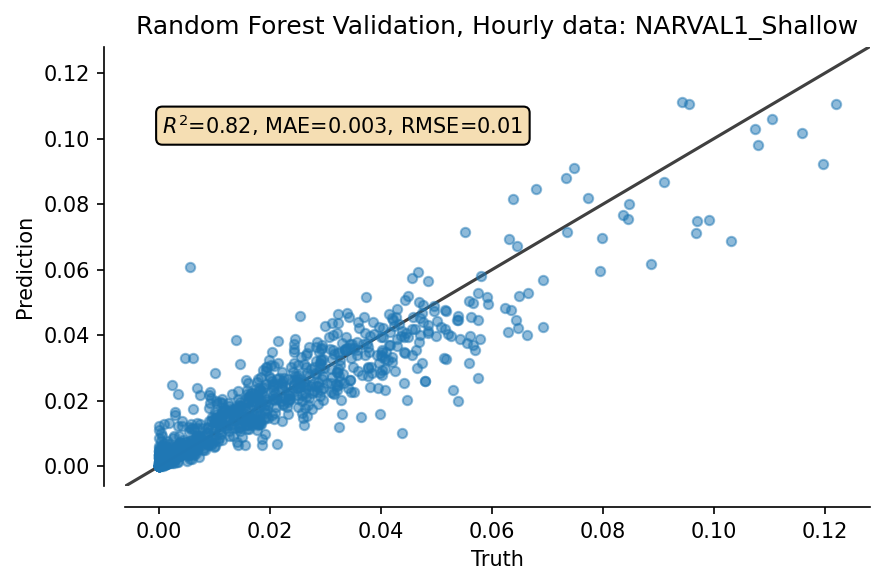

In [10]:
from sklearn.metrics import mean_squared_error

""" Validation plot """
fig, ax = plt.subplots(dpi=150)

plot_results(ax, truth_RF, pred_RF, title="Random Forest Validation, Hourly data: NARVAL1_Shallow")

fig.tight_layout()

### Now, retrain model on all data, and extrapolate over whole space

In [11]:
X_train = params.to_numpy()
Y_train = precip.ravel()
model = rf_model(X_train, Y_train)

In [12]:
model.train()

In [13]:
%%time

# Now, make grid for plotting RF predictions
# more n_points means higher resolution, but takes exponentially longer
n_points = 30 

min_vals = params.min()
max_vals = params.max()

# For uniform prediction over full params space
space=np.linspace(min_vals, max_vals, n_points)

# Reshape to (N,D)
reshape_to_ND = np.transpose(space)
Xs_uniform = np.meshgrid(*reshape_to_ND)
test = np.array([_.flatten() for _ in Xs_uniform]).T

# Predict
predictions,_ = model.predict(test) 
predictions   = predictions.reshape(Xs_uniform[0].shape)

# Now, take mean over all parameters except [LWP, z700], assumed to be first 2 indices
predictions_reduced = np.mean(predictions, axis=tuple(range(2, predictions.ndim)))

Wall time: 1min 35s


In [14]:
# Now, make grid for plotting RF predictions

LWP_grid   = np.linspace(min_vals['LWP'], max_vals['LWP'], num=n_points)
zg700_grid = np.linspace(min_vals['zg700'], max_vals['zg700'], num=n_points)

lwp, zg = np.meshgrid(LWP_grid, zg700_grid)


## Plot!

C:\Users\duncan\AppData\Local\Temp/ipykernel_21624/1073200818.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cp = ax[0].pcolormesh(LWP_grid, zg700_grid,


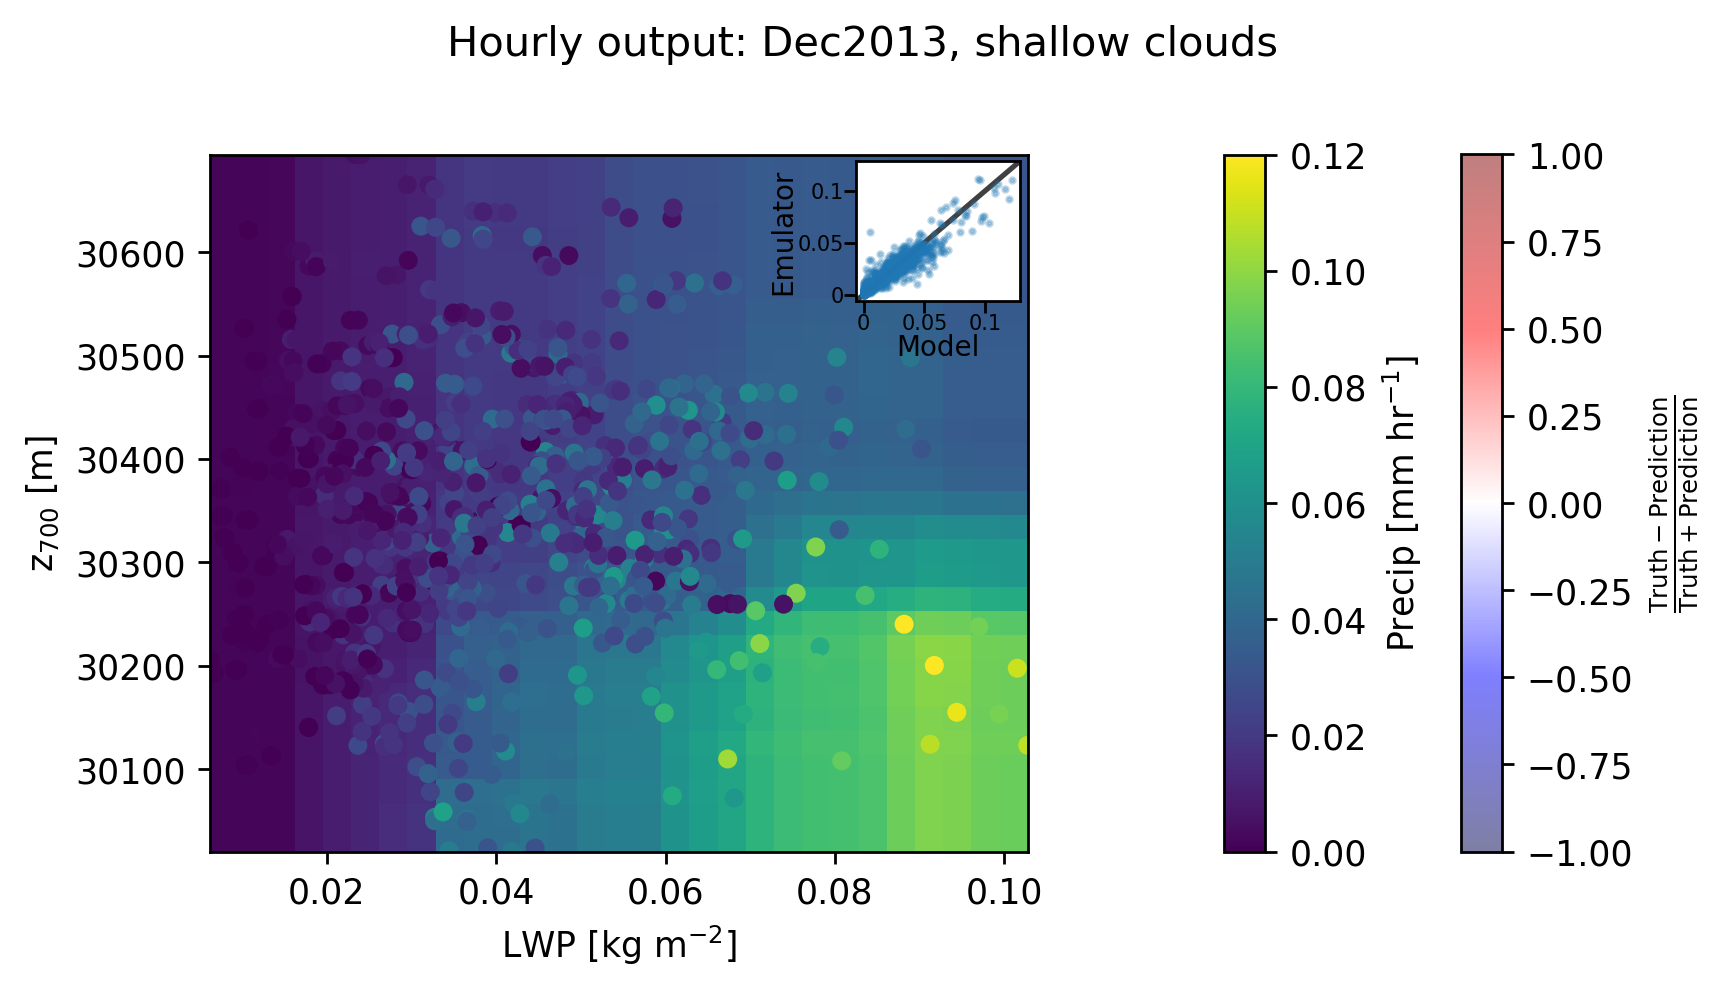

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(7,4), dpi=250, gridspec_kw={'width_ratios':[1, 0.05, 0.05]})
fig.suptitle("Hourly output: Dec2013, shallow clouds")

cp = ax[0].pcolormesh(LWP_grid, zg700_grid,
                      predictions_reduced, vmin=0, vmax=0.12, alpha=1)

fig.colorbar(cp, cax=ax[1], orientation='vertical', shrink=0.05, label=r'Precip [mm hr$^{-1}$]')

"""Overlap errors"""
ax[0].scatter(df_crm['LWP'], df_crm['zg700'], c=df_crm['precip'], 
                    vmin=0, vmax=0.12, s=30, marker='o', edgecolors="None")

ers = ax[0].scatter(df_crm['LWP'], df_crm['zg700'], c=(truth_RF-pred_RF)/(truth_RF+pred_RF), facecolors="None", 
                    vmin=-1, vmax=1, s=30, marker='o', lw=0.7, alpha=0.5, cmap='seismic') 
ers.set_facecolors("None")
fig.colorbar(ers, cax=ax[2], label=r'$\frac{\mathrm{Truth-Prediction}}{\mathrm{Truth+Prediction}}$')

for idx, _ in enumerate(ax[:1]):
    _.set_xlabel(r'LWP [kg m$^{-2}$]')
    _.set_ylabel(r'z$_{700}$ [m]')
    
    if idx==0:
        _.set_xlim(min_vals['LWP'], max_vals['LWP'])
        _.set_ylim(min_vals['zg700'], max_vals['zg700'])

        
fig.tight_layout()
fig.subplots_adjust(top=0.85) # Put this AFTER tight_layout() call ! 

"""Add validation plot as inset to first axis"""
axins = ax[0].inset_axes([0.79, 0.79, 0.2, 0.2], # x0, y0, width, height
                          transform=ax[0].transAxes) 
axins.scatter(truth_RF, pred_RF, s=2, alpha=0.3)
add_121_line(axins)
axins.set_xlabel('Model', position=(0.5,0), fontsize=8, labelpad=-0.01)
axins.set_xticks([0, 0.05, 0.1])
axins.set_xticklabels(labels=[0, 0.05, 0.1], fontdict={'fontsize':6})

axins.set_ylabel('Emulator', position=(0,0.5), fontsize=8, labelpad=-0.01)
axins.set_yticks([0, 0.05, 0.1])
axins.set_yticklabels(labels=[0, 0.05, 0.1], fontdict={'fontsize':6})

axins.tick_params(axis='both', which='major', pad=0.01)

#plt.savefig("./Figs/1hr_D13shal_lwp-zg700-pr_w-errorpoints.png", dpi=300)